<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 2. Load data
file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:
# 3. Preprocessing (seperti sebelumnya)
df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])
le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])
le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

In [6]:
# 4. Filter hanya transaksi keluar (pengeluaran)
df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [7]:
# 5. Agregasi per user per bulan
agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()

agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [8]:
# 6. Tambah fitur rolling: pengeluaran bulan lalu & rata-rata 3 bulan terakhir
agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values

In [9]:
# 7. Tambah fitur rolling std/min/max dan trend
agg['rolling3_std'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).std().shift(1).values
agg['rolling3_min'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).min().shift(1).values
agg['rolling3_max'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).max().shift(1).values

In [10]:
# Fitur trend: perubahan relatif pengeluaran dibanding bulan lalu
agg['trend_bulan'] = (agg['total_pengeluaran'] - agg['pengeluaran_bulan_lalu']) / (agg['pengeluaran_bulan_lalu'] + 1)

In [11]:
# 8. Target prediksi: total_pengeluaran bulan berikutnya (per user)
agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [12]:
# 9. Drop baris yang tidak lengkap
agg = agg.dropna(subset=['target', 'pengeluaran_bulan_lalu', 'rolling3_pengeluaran', 'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan']).reset_index(drop=True)

In [13]:
# 10. Split data: train = tahun < 2024, test = tahun == 2024
train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [14]:
# 11. Transformasi log pada target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [15]:
# 12. Model XGBoost dengan target log
model = XGBRegressor(n_estimators=150, max_depth=4, learning_rate=0.1, random_state=42, n_jobs=-1)
model.fit(X_train, y_train_log)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
# 13. Prediksi (skala log), lalu konversi kembali ke rupiah
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

In [18]:
# 14. Evaluasi
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 6927940.01
RMSE: 11009674.34
MAPE: 422.69%


In [19]:
# 15. Evaluasi MAPE pada target > 200 ribu
mask = y_test > 200000
if mask.sum() > 0:
    mape_200k = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE (target > 200k): {mape_200k:.2f}%")
else:
    print("Tidak ada data target > 200 ribu.")

MAPE (target > 200k): 190.55%


In [20]:
# 16. Baseline: prediksi = pengeluaran bulan lalu
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}, Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAE: 8093284.09, Baseline MAPE: 674.36%


In [21]:
# 17. Error pada 10 data target terkecil (dengan penyesuaian index!)
print("\n10 Data Target Terkecil dan Error Prediksinya:")
for idx in y_test.nsmallest(10).index:
    pos = y_test.index.get_loc(idx)
    print(f"Target: {y_test.loc[idx]:.0f}, Prediksi: {y_pred[pos]:.0f}, Error: {abs(y_test.loc[idx] - y_pred[pos]):.0f}")


10 Data Target Terkecil dan Error Prediksinya:
Target: 39424, Prediksi: 2662110, Error: 2622686
Target: 106026, Prediksi: 9850972, Error: 9744946
Target: 186391, Prediksi: 6768130, Error: 6581739
Target: 274454, Prediksi: 10082369, Error: 9807915
Target: 343621, Prediksi: 2729787, Error: 2386166
Target: 581357, Prediksi: 990049, Error: 408692
Target: 599716, Prediksi: 1803654, Error: 1203938
Target: 614926, Prediksi: 8388971, Error: 7774045
Target: 854015, Prediksi: 3394882, Error: 2540867
Target: 866519, Prediksi: 4785853, Error: 3919334


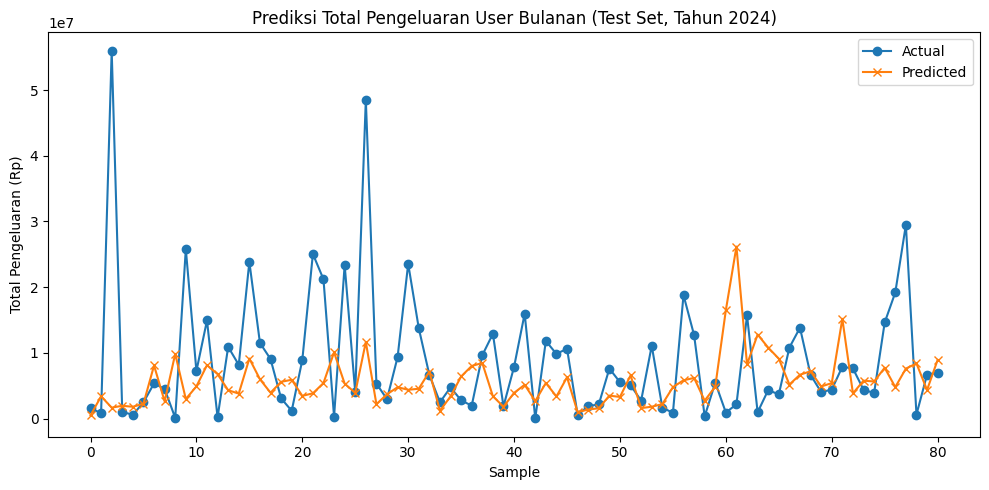

In [22]:
# 18. Visualisasi hasil prediksi vs aktual (skala asli)
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()


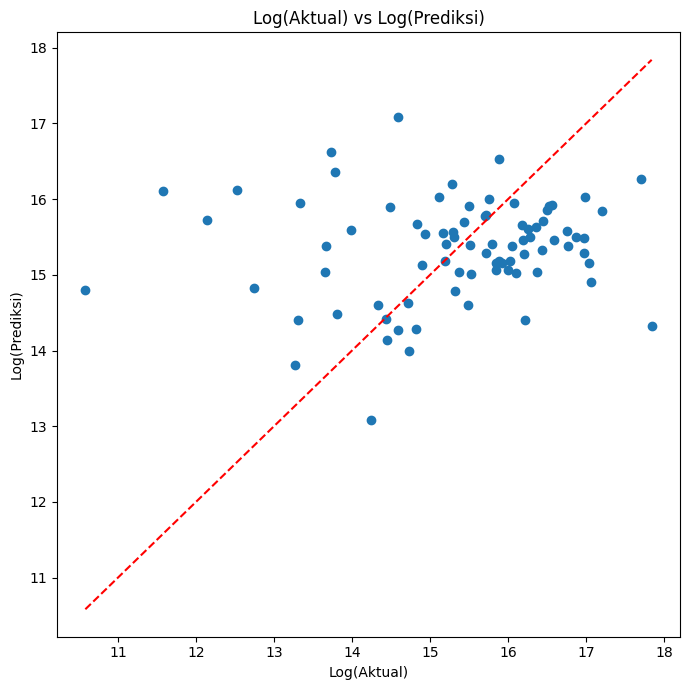

In [23]:
# 19. Visualisasi scatter log(Aktual) vs log(Prediksi)
plt.figure(figsize=(7,7))
plt.scatter(np.log1p(y_test), np.log1p(y_pred))
plt.xlabel("Log(Aktual)")
plt.ylabel("Log(Prediksi)")
plt.title("Log(Aktual) vs Log(Prediksi)")
plt.plot([min(np.log1p(y_test)), max(np.log1p(y_test))], [min(np.log1p(y_test)), max(np.log1p(y_test))], 'r--')
plt.tight_layout()
plt.show()